In [3]:
import matplotlib.pyplot as plt
from collections import namedtuple
import jax.numpy as jnp
import jax
from statsmodels.api import Poisson

jax.config.update("jax_enable_x64", True)

In [4]:
@jax.jit
def logL(β):
    return -(β - 10) ** 2 - 10


In [5]:
dlogL = jax.vmap(jax.grad(logL))

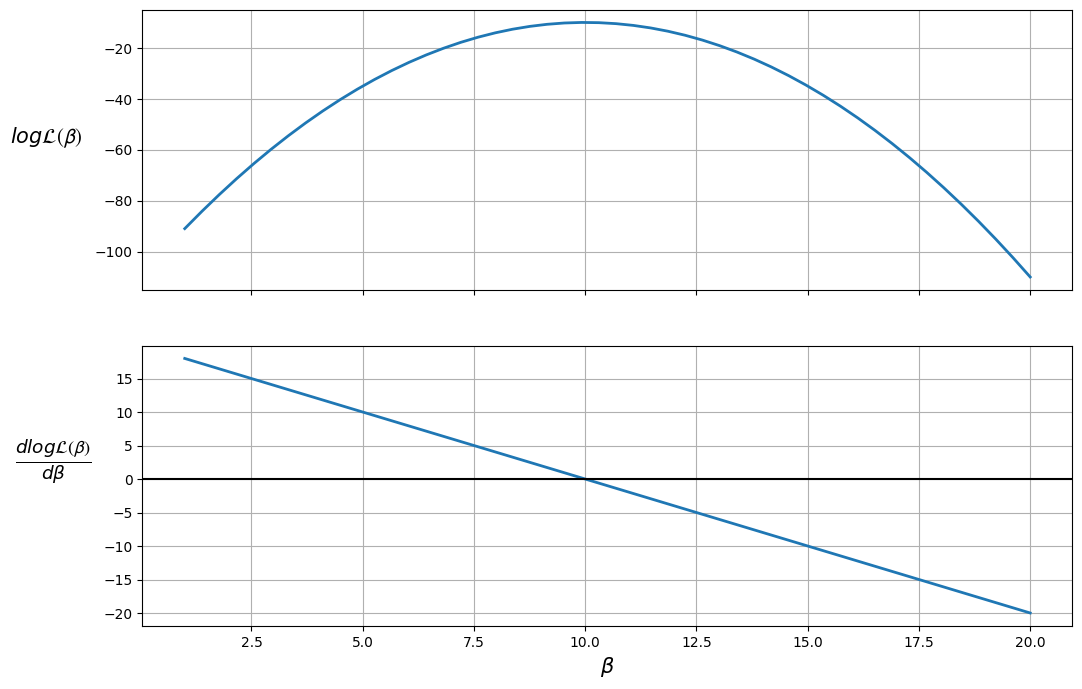

In [6]:
β = jnp.linspace(1, 20)

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12, 8))

ax1.plot(β, logL(β), lw=2)
ax2.plot(β, dlogL(β), lw=2)

ax1.set_ylabel(r'$log \mathcal{L(\beta)}$',
               rotation=0,
               labelpad=35,
               fontsize=15)
ax2.set_ylabel(r'$\frac{dlog \mathcal{L(\beta)}}{d \beta}$ ',
               rotation=0,
               labelpad=35,
               fontsize=19)

ax2.set_xlabel(r'$\beta$', fontsize=15)
ax1.grid(), ax2.grid()
plt.axhline(c='black')
plt.show()

In [7]:
RegressionModel = namedtuple('RegressionModel', ['X', 'y'])

def create_regression_model(X, y):
    n, k = X.shape
    # Reshape y as a n_by_1 column vector
    y = y.reshape(n, 1)
    X, y = jax.device_put((X, y))
    return RegressionModel(X=X, y=y)

In [8]:
@jax.jit
def _factorial(n):
    return jax.lax.exp(jax.lax.lgamma(n + 1.0)).astype(int)

jax_factorial = jax.vmap(_factorial)

In [21]:
@jax.jit
def neg_poisson_logL(b, model):
    y = model.y
    μ = jnp.exp(model.X @ b)
    return -jnp.sum(model.y * jnp.log(μ) - μ - jnp.log(jax_factorial(y)))

In [22]:
X = jnp.array([[1, 2, 5],
               [1, 1, 3],
               [1, 4, 2],
               [1, 5, 2],
               [1, 3, 1]])

y = jnp.array([1, 0, 1, 1, 0])

# Take a guess at initial βs
init_b = jnp.array([0.1, 0.1, 0.1]).reshape(X.shape[1], 1)

# Create an object with Poisson model values
poi = create_regression_model(X, y)

In [23]:
print(poi.X)

[[1 2 5]
 [1 1 3]
 [1 4 2]
 [1 5 2]
 [1 3 1]]


In [24]:
print(init_b)

[[0.1]
 [0.1]
 [0.1]]


In [25]:
import jaxopt

In [39]:
solver_1 = jaxopt.ScipyMinimize(method = "l-bfgs-b", fun=neg_poisson_logL, tol = 1e-12, maxiter=5000)
solver_1_sol = solver_1.run(init_b, poi)
print(solver_2_sol.params)

[[-6.07860721]
 [ 0.9334189 ]
 [ 0.84331384]]


In [43]:
solver_1_sol.state.success

True

In [38]:
solver_2 = jaxopt.LBFGS(fun=neg_poisson_logL, maxiter = 5000)
solver_2_sol = solver_2.run(init_b, poi)
print(solver_2_sol.params)

[[-6.07860721]
 [ 0.9334189 ]
 [ 0.84331384]]


In [42]:
solver_2_sol.state.num_fun_eval

Array(47, dtype=int32)